In [1]:
import os
# Standard library imports
import re

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# Text preprocessing
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
# Model evaluation & selection
from sklearn.model_selection import train_test_split

# tensorflow
import tensorflow as tf

tf.get_logger().setLevel('ERROR')
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, BatchNormalization
# Progress bar
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)

In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/karyo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Step 1. Problem and Data Description

### Challenge Problem

The goal of this project is to build a Recurrent Neural Network (RNN) model capable of classifying tweets as either relating to real disasters (1) or not (0). This involves utilizing NLP techniques to analyze and understand the textual content of tweets. The assignment is based on a Kaggle competition titled "Natural Language Processing with Disaster Tweets."

### Natural Language Processing (NLP)

NLP is a field of artificial intelligence that focuses on the interaction between computers and humans through natural language. Key tasks in NLP include text preprocessing, tokenization, part-of-speech tagging, named entity recognition, and sentiment analysis. In this challenge, NLP techniques will be utilized to preprocess the tweet text, extract meaningful features, and build models that can accurately classify the tweets.

### Data Description

The dataset provided for this challenge consists of 10,000 hand-classified tweets, split into training and test sets. The training dataset contains 7,613 entries with the following columns:

- **id:** Unique identifier for each tweet.
- **keyword:** A specific keyword from the tweet (may be blank).
- **location:** Origin of the tweet (may be blank).
- **text:** Content of the tweet.
- **target:** Indicates if the tweet is about a real disaster (1) or not (0).

#### Size and Dimensions

- **Training Set:** 7,613 tweets, of which 4,342 are non disaster tweets (0) and 3,271 are disaster tweets (1). This shows a fairly balanced distribution, with a slight majority of non-disaster tweets.
- **Test Set:** 3,263 tweets.
- **Columns:** 6 columns (`id`, `keyword`, `location`, `text`, `text_length`, `target`). (`target` is absent in the test set).

#### Structure

- **id:** Integer type, no missing values.
- **keyword:** String, 61 and 26 missing values in the training and the test sets respectively.
- **location:** String, 2,533 and 1,105 missing values in the training and the test sets respectively.
- **text:** String, no missing values.
- **target:** Integer type, no missing values.

The target variable distribution is fairly balanced, with approximately 57% of the tweets labeled as non-disaster (0) and 43% labeled as disaster (1).

In [2]:
# Load the datasets
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

# Display the first few rows of the train and test datasets
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [3]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [4]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


(None, None)

In [5]:
df_train[df_train['target'] == 0].count()

id          4342
keyword     4323
location    2884
text        4342
target      4342
dtype: int64

# 2. Exploratory Data Analysis (EDA)

## A. Visualizations

### 1. Target Variable Distribution
- Plot the distribution of the target variable to understand the balance of disaster and non-disaster tweets.
  - Use a bar plot or pie chart to visualize the proportion of each class.

### 2. Keyword and Location Frequency Analysis
- Analyze the frequency of the top keywords and locations in the training dataset.
  - Create bar plots for the most common keywords and locations.
  - Investigate any correlation between specific keywords/locations and the target variable.

### 3. Tweet Length Distribution
- Plot the distribution of tweet lengths in both training and testing datasets.
  - Use histograms to visualize the distribution of tweet lengths.
  - Compare the length distributions between disaster and non-disaster tweets.

### 4. Most Common Words
- Visualize the most common words in disaster and non-disaster tweets using word clouds.
  - Create separate word clouds for each class to identify distinctive vocabulary.

### 5. Missing Values Analysis
- Analyze the missing values in the datasets.
  - Use a heatmap or bar plot to visualize the proportion of missing values in each column.

## B. Data Cleaning Procedures

### 1. Handling Missing Values
- Develop a strategy for missing values in the keyword and location columns:
  - Option 1: Fill missing values with a placeholder (e.g., "Unknown").
  - Option 2: Drop rows with missing values if they are not significant.
  - Analyze the impact of each approach on the dataset.

### 2. Text Preprocessing
- Implement a comprehensive text cleaning pipeline:
  - Convert all text to lowercase.
  - Remove special characters and punctuation.
  - Remove or replace URLs and user mentions.
  - Remove stop words.
  - Consider stemming or lemmatization to reduce words to their base form.

## C. Analysis Plan

1. Conduct a thorough examination of the visualizations and cleaned data.
2. Identify patterns or trends that might be useful for feature engineering.
3. Investigate any potential correlations between features and the target variable.
4. Formulate hypotheses about what factors might be most predictive of disaster tweets.
5. Document insights and potential strategies for model development based on the EDA findings.

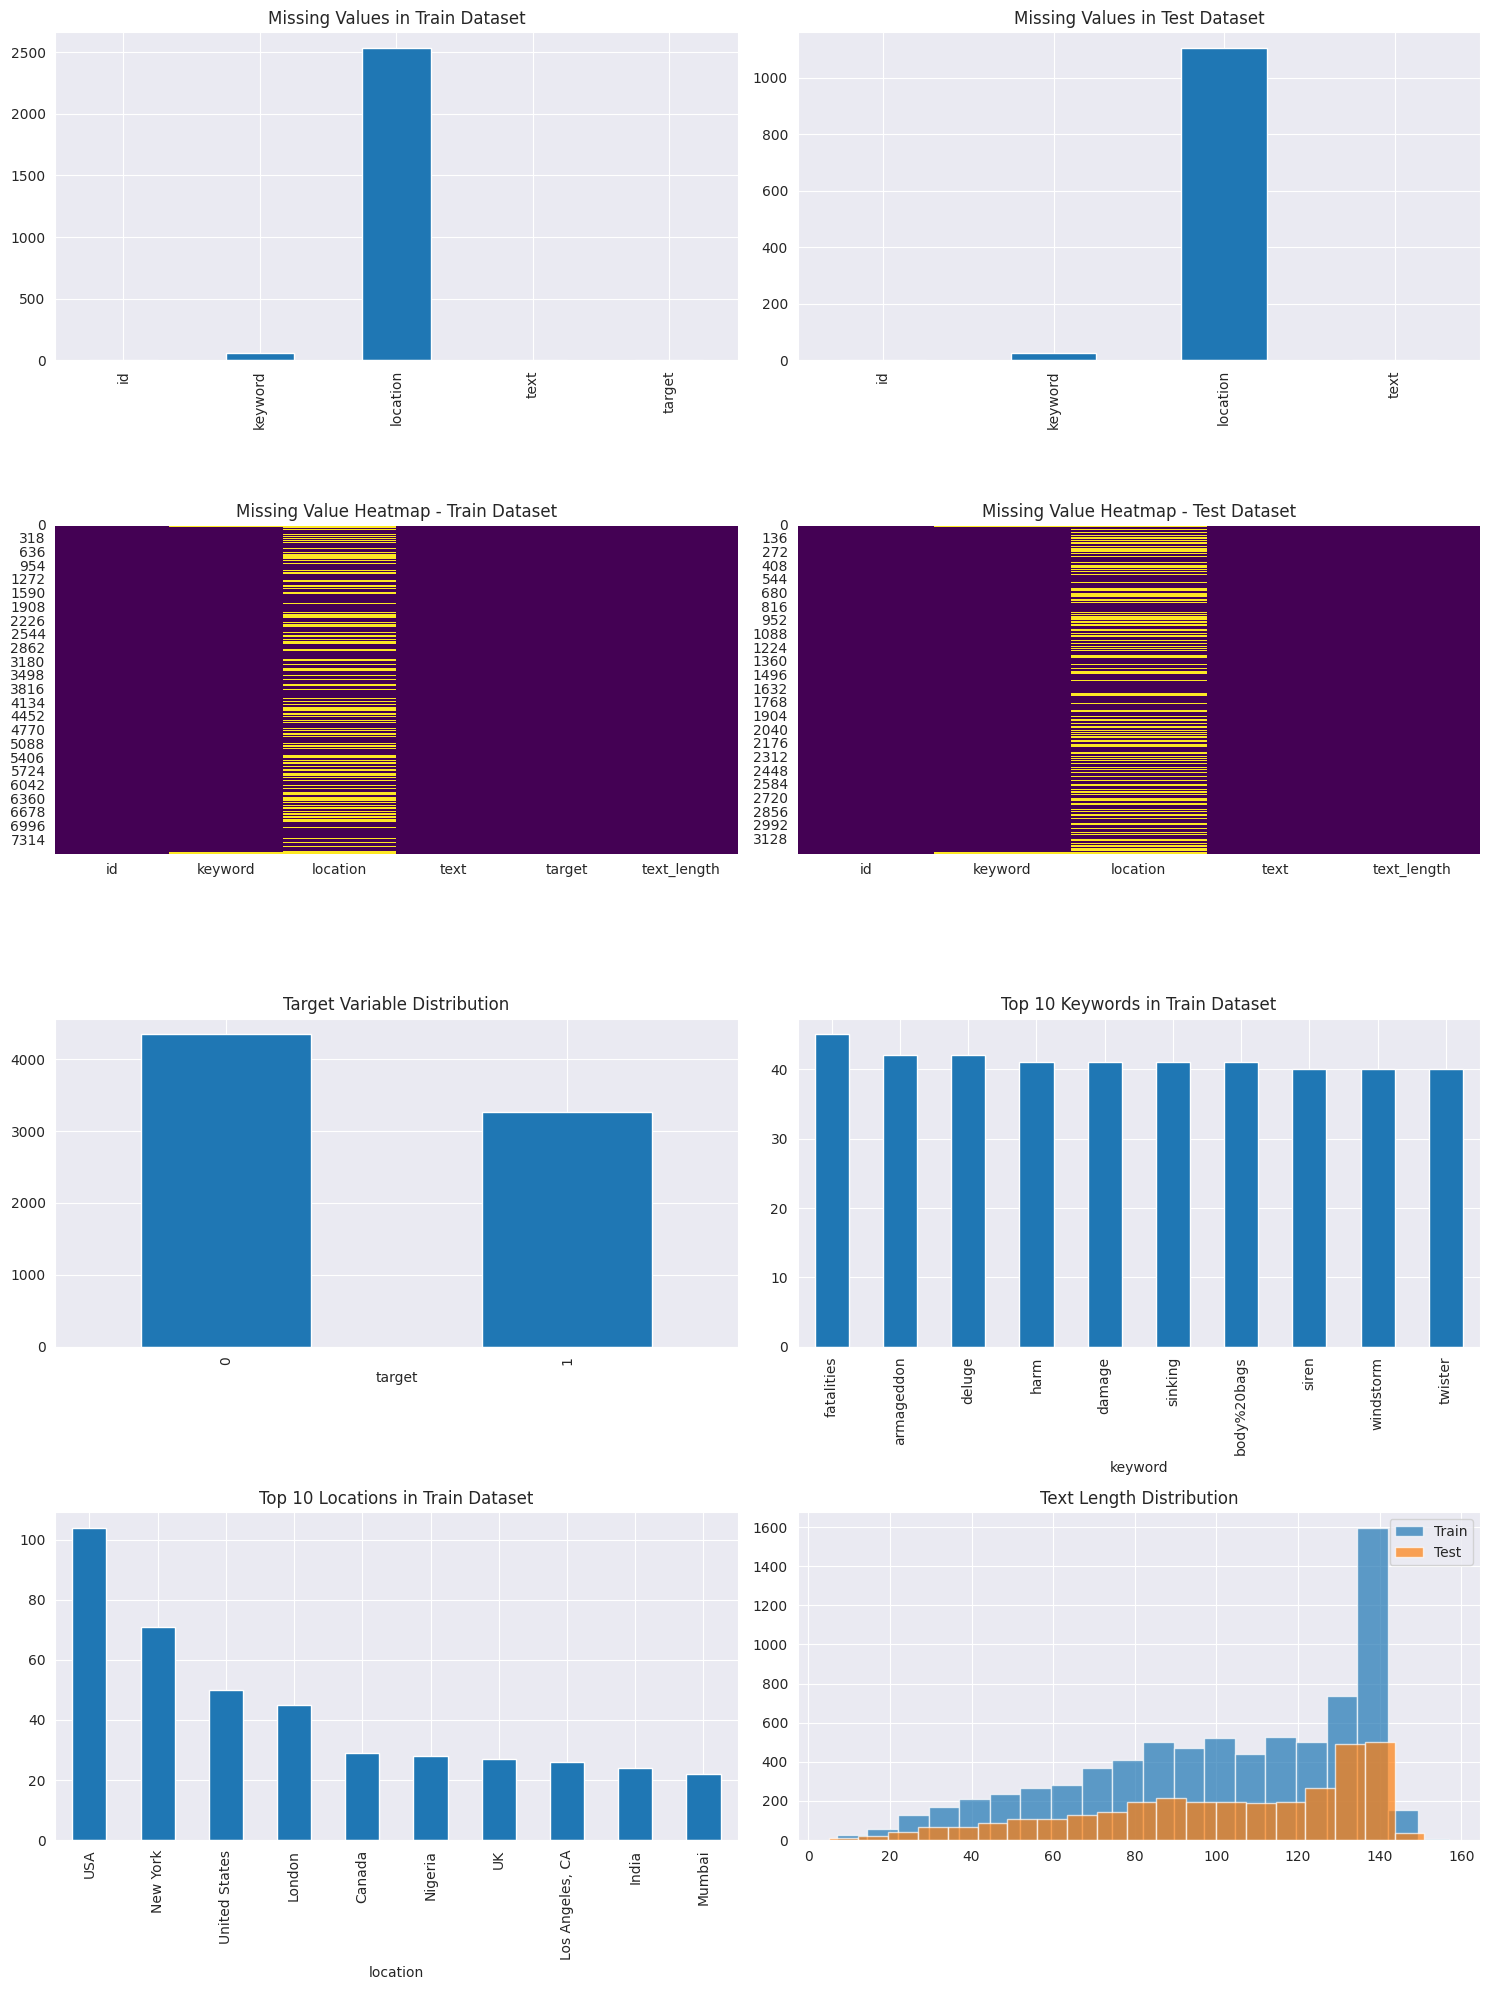

(id             0
 keyword       61
 location    2533
 text           0
 target         0
 dtype: int64,
 id             0
 keyword       26
 location    1105
 text           0
 dtype: int64,
 target
 0    4342
 1    3271
 Name: count, dtype: int64,
 keyword
 fatalities     45
 armageddon     42
 deluge         42
 harm           41
 damage         41
 sinking        41
 body%20bags    41
 siren          40
 windstorm      40
 twister        40
 Name: count, dtype: int64,
 location
 USA                104
 New York            71
 United States       50
 London              45
 Canada              29
 Nigeria             28
 UK                  27
 Los Angeles, CA     26
 India               24
 Mumbai              22
 Name: count, dtype: int64)

In [6]:
# Check for missing values
missing_values_train = df_train.isnull().sum()
missing_values_test = df_test.isnull().sum()

# Target variable distribution in train dataset
target_distribution = df_train['target'].value_counts()

# Keyword and location frequency analysis
top_keywords = df_train['keyword'].value_counts().head(10)
top_locations = df_train['location'].value_counts().head(10)

# Text length distribution
df_train['text_length'] = df_train['text'].apply(len)
df_test['text_length'] = df_test['text'].apply(len)

# Plotting
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

# Missing values
missing_values_train.plot(kind='bar', ax=axes[0, 0], title='Missing Values in Train Dataset')
missing_values_test.plot(kind='bar', ax=axes[0, 1], title='Missing Values in Test Dataset')

# Missing value heatmaps
sns.heatmap(df_train.isnull(), ax=axes[1, 0], cbar=False, cmap='viridis')
axes[1, 0].set_title('Missing Value Heatmap - Train Dataset')
sns.heatmap(df_test.isnull(), ax=axes[1, 1], cbar=False, cmap='viridis')
axes[1, 1].set_title('Missing Value Heatmap - Test Dataset')

# Target distribution
target_distribution.plot(kind='bar', ax=axes[2, 0], title='Target Variable Distribution')

# Top keywords and locations
top_keywords.plot(kind='bar', ax=axes[2, 1], title='Top 10 Keywords in Train Dataset')
top_locations.plot(kind='bar', ax=axes[3, 0], title='Top 10 Locations in Train Dataset')

# Text length distribution
axes[3, 1].hist(df_train['text_length'], bins=20, alpha=0.7, label='Train')
axes[3, 1].hist(df_test['text_length'], bins=20, alpha=0.7, label='Test')
axes[3, 1].set_title('Text Length Distribution')
axes[3, 1].legend()

plt.tight_layout()
plt.show()

missing_values_train, missing_values_test, target_distribution, top_keywords, top_locations

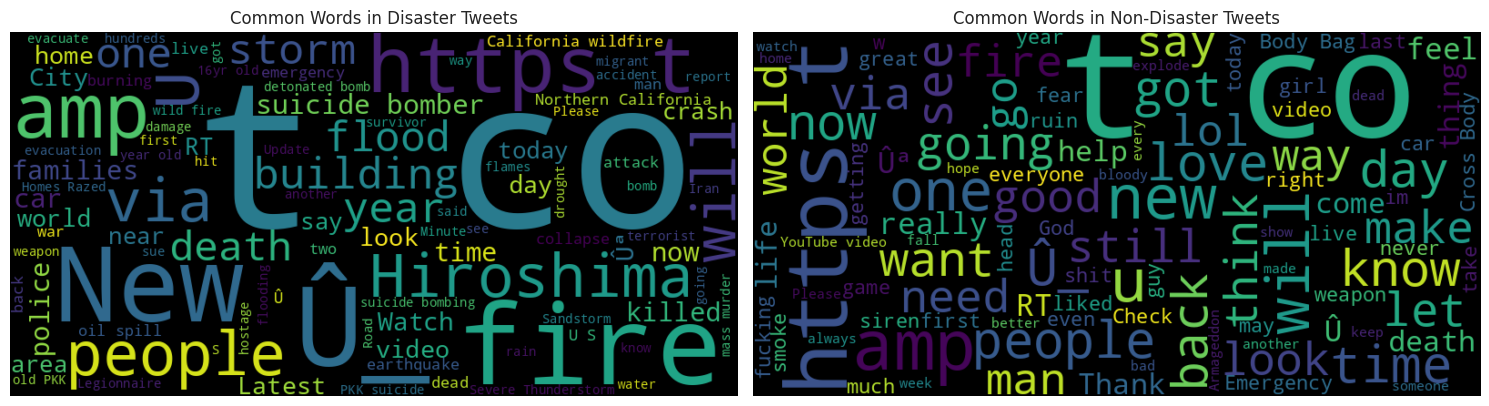

In [7]:
# Most common words in disaster and non-disaster tweets
disaster_tweets = df_train[df_train['target'] == 1]['text']
non_disaster_tweets = df_train[df_train['target'] == 0]['text']

disaster_wordcloud = WordCloud(width=800, height=400, max_words=100).generate(' '.join(disaster_tweets))
non_disaster_wordcloud = WordCloud(width=800, height=400, max_words=100).generate(' '.join(non_disaster_tweets))

# Plot word clouds
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].imshow(disaster_wordcloud, interpolation='bilinear')
axes[0].set_title('Common Words in Disaster Tweets')
axes[0].axis('off')

axes[1].imshow(non_disaster_wordcloud, interpolation='bilinear')
axes[1].set_title('Common Words in Non-Disaster Tweets')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Data Cleaning and preprocessing

In [8]:
ps = PorterStemmer()


def clean_text(text: str) -> str:
    """Clean the input text by lowercasing, removing special characters and extra spaces."""
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces and strip
    return text


def tokenize_and_stem(text: str) -> str:
    """Tokenize the text and apply stemming."""
    tokens = word_tokenize(text)  # Tokenize the text
    stemmed_tokens = [ps.stem(token) for token in tokens]  # Stem each token
    return ' '.join(stemmed_tokens)  # Join the tokens back into a string


# Data Cleaning and preprocessing
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    # Fill missing values
    df = df.fillna({'keyword': '', 'location': ''})

    # Apply text cleaning
    df['cleaned_text'] = df['text'].apply(clean_text)

    # Apply tokenization and stemming
    df['tokenized_text'] = df['cleaned_text'].apply(tokenize_and_stem)

    return df

In [11]:
df_train = preprocess_data(df_train)
df_test = preprocess_data(df_test)
test_ids = df_test[['id']]

# Display cleaned data
df_train[['text', 'cleaned_text']].head()

,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",13 000 people receive wildfires evacuation ord...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...


# 3. Model Architecture



In [12]:
# Tokenization parameters
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_train['tokenized_text'])
sequences = tokenizer.texts_to_sequences(df_train['tokenized_text'])
padded_sequences = pad_sequences(sequences)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df_train['target'], test_size=0.2, random_state=42)

# Model definition

In [14]:
# Hyperparameters
embedding_dim = 256
lstm_units = 128
dropout_rate = 0.3
learning_rate = 0.001

# Build the improved bidirectional LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim))
model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(lstm_units)))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

I0000 00:00:1722856486.889639   87740 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722856487.025947   87740 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722856487.025993   87740 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722856487.030211   87740 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722856487.030250   87740 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

# . Training and Evaluation

In [15]:
epochs = 50
batch_size = 5120
# Train the model
history = model.fit(X_train, np.array(y_train), epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.4856 - loss: 0.9651 - val_accuracy: 0.6314 - val_loss: 0.6908
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ -8s -8477611us/step - accuracy: 0.6112 - loss: 0.8269 - val_accuracy: 0.6593 - val_loss: 0.6897
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.6406 - loss: 0.7481 - val_accuracy: 0.5690 - val_loss: 0.6885
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.6576 - loss: 0.6532 - val_accuracy: 0.5624 - val_loss: 0.6874
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.6880 - loss: 0.6182 - val_accuracy: 0.5624 - val_loss: 0.6857
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.7486 - loss: 0.5230 - val_accuracy: 0.5624 - val_loss: 0.6841
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.7894 - loss: 0.4591 - val_accuracy: 0.5632 - val_loss: 0.6827
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8212 - loss: 0.4152 - val_accuracy: 0.5649 - val_

In [16]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, np.array(y_test))
print(f'Test Accuracy: {accuracy}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7558 - loss: 0.5508
Test Accuracy: 0.7688772082328796


# .Predicting and Submission

In [17]:
# Prepare test data for prediction
sequences = tokenizer.texts_to_sequences(df_test['text'])
pad_seq = pad_sequences(sequences)

In [18]:
# Make predictions on the padded sequences and convert to binary values (1 if prediction >= 0.5, else 0)
predicted_labels = np.where(model.predict(pad_seq) >= 0.5, 1, 0)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [19]:
# Create submission DataFrame and save to CSV
df = pd.DataFrame({'id': test_ids['id'], 'target': predicted_labels.flatten()})
df.to_csv('submission_tf.csv', index=False)